In [18]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [19]:
import numpy as np
import pandas as pd
import datetime as dt

## Reflect Tables into SQLALchemy ORM

In [20]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [21]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [22]:
# reflect an existing database into a new model
base = automap_base()
# reflect the tables
base.prepare(engine, reflect = True)

In [23]:
# View all of the classes that automap found
base.classes.keys()

['measurement', 'station']

In [24]:
# Save references to each table
measurement = base.classes.measurement
station = base.classes.station

In [25]:
# Create our session (link) from Python to the DB
session = Session(engine)

## Bonus Challenge Assignment: Temperature Analysis II

In [26]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, maximum, and average temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(measurement.tobs), func.avg(measurement.tobs), func.max(measurement.tobs)).\
        filter(measurement.date >= start_date).filter(measurement.date <= end_date).all()

# For example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [27]:
# Use the function `calc_temps` to calculate the tmin, tavg, and tmax 
# for a year in the data set
temps = calc_temps('2017-08-01', '2017-08-07')

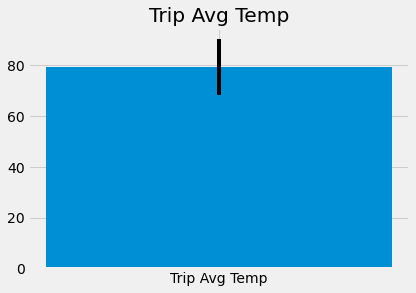

In [28]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for bar height (y value)
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

plt.bar('Trip Avg Temp', temps[0][1], yerr=(temps[0][2] - temps[0][0]))
plt.tight_layout()
plt.title("Trip Avg Temp")
plt.show()

### Daily Rainfall Average

In [29]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's 
# matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

rainfall = session.query(measurement.station, station.name, station.latitude, station.longitude, station.elevation,func.sum(measurement.prcp)).\
    filter(measurement.station == station.station).\
    filter(measurement.date >= '2017-08-01').\
    filter(measurement.date <= '2017-08-07').group_by(measurement.station).order_by(func.sum(measurement.prcp).desc()).all()
rainfall


[('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 0.36),
 ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, 0.22),
 ('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9, 0.06),
 ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.04),
 ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, 0.0)]

In [30]:
# Use this function to calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(measurement.tobs), func.avg(measurement.tobs), func.max(measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", measurement.date) == date).all()

# For example
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [31]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`
normals=[]
# Set the start and end date of the trip
start_date = '2017-08-01'
end_date = '2017-08-07'

# Use the start and end date to create a range of dates
def split_date(date):
    year, month, day = date.split('-')
    new_date = dt.date(int(year), int(month), int(day))
    return new_date

# Strip off the year and save a list of strings in the format %m-%d
dates = []
for n in range((split_date(end_date) - split_date(start_date)).days + 1):
    date = split_date(start_date) + dt.timedelta(n)
    dates.append(date.strftime('%m-%d'))
dates

# Use the `daily_normals` function to calculate the normals for each date string 
for date in dates:
    normals.append(daily_normals(date)[0])

# and append the results to a list called `normals`.
normals



[(67.0, 75.54, 83.0),
 (68.0, 75.60377358490567, 84.0),
 (70.0, 76.61111111111111, 85.0),
 (69.0, 76.71153846153847, 84.0),
 (69.0, 76.14814814814815, 82.0),
 (67.0, 76.25, 83.0),
 (71.0, 77.15686274509804, 83.0)]

In [32]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
trip_df = pd.DataFrame(normals, columns=['Min Temp', 'Max Temp', 'Avg Temp'])
trip_df['Dates'] = dates
trip_df = trip_df.set_index('Dates')
trip_df

,Min Temp,Max Temp,Avg Temp
Dates,,,
08-01,67.0,75.540000,83.0
08-02,68.0,75.603774,84.0
08-03,70.0,76.611111,85.0
08-04,69.0,76.711538,84.0
08-05,69.0,76.148148,82.0
08-06,67.0,76.250000,83.0
08-07,71.0,77.156863,83.0


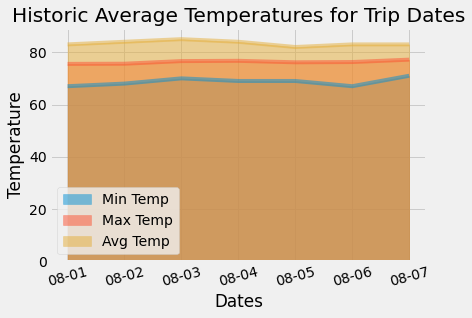

In [33]:
# Plot the daily normals as an area plot with `stacked=False`
trip_df.plot(kind='area', stacked=False)
plt.title('Historic Average Temperatures for Trip Dates')
plt.xticks(rotation=15)
plt.ylabel('Temperature')
plt.show()

## Close Session

In [34]:
session.close()